# Определение стоимости автомобилей

В приложении, по продаже авто, хорошо бы иметь функцию определения рыночной стоимости.  
Имеются данные: технические характеристики, комплектации и цены автомобилей.  
Построим модель для определения стоимости.  

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:  

`DateCrawled` — дата скачивания анкеты из базы  
`VehicleType` — тип автомобильного кузова  
`RegistrationYear` — год регистрации автомобиля  
`Gearbox` — тип коробки передач  
`Power` — мощность (л. с.)  
`Model` — модель автомобиля  
`Kilometer` — пробег (км)  
`RegistrationMonth` — месяц регистрации автомобиля  
`FuelType` — тип топлива  
`Brand` — марка автомобиля  
`NotRepaired` — была машина в ремонте или нет  
`DateCreated` — дата создания анкеты  
`NumberOfPictures` — количество фотографий автомобиля  
`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
`LastSeen` — дата последней активности пользователя  

Целевой признак:  

`Price` — цена (евро)

## Подготовка данных

In [1]:

import random
import warnings
import numpy as np
import pandas as pd
!pip install seaborn -U
import seaborn as sns
sns.set(style='whitegrid')
import lightgbm as lgb
!pip install scikit-learn -U
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
warnings.simplefilter(action='ignore')
pd.set_option('display.max_rows', 300)
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
pd.set_option('display.max_colwidth', 200)
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.24.2)


In [2]:
df = pd.read_csv('autos.csv')

In [3]:
df.sample(n=10, random_state=12345)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46
63295,2016-03-07 12:55:48,11000,wagon,2010,auto,177,5er,150000,10,gasoline,bmw,no,2016-03-07 00:00:00,0,6237,2016-04-04 02:16:33
299143,2016-03-24 17:48:59,1200,small,2003,NaN,58,clio,150000,3,petrol,renault,no,2016-03-24 00:00:00,0,25551,2016-03-24 17:48:59
236634,2016-03-27 09:57:43,12500,convertible,1977,auto,177,sl,150000,5,petrol,mercedes_benz,no,2016-03-27 00:00:00,0,53177,2016-03-27 10:38:40
44603,2016-04-02 18:38:59,1599,NaN,2016,manual,50,arosa,125000,10,NaN,seat,no,2016-04-02 00:00:00,0,2991,2016-04-06 18:16:10
251416,2016-03-20 23:53:52,1999,small,2002,manual,75,corsa,150000,1,petrol,opel,NaN,2016-03-20 00:00:00,0,46537,2016-03-21 04:41:29


Переименуем столбцы в `snake_case`:

In [4]:

snake_case_columns =\
[
    'date_crawled',
    'price',
    'vehicle_type',
    'registration_year',
    'gearbox',
    'power',
    'model',
    'kilometer',
    'registration_month',
    'fuel_type',
    'brand',
    'not_repaired',
    'date_created',
    'number_of_pictures',
    'postal_code',
    'last_seen'
]


In [5]:

df.set_axis(snake_case_columns, axis=1, inplace=True)
list(df)


['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'not_repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
date_crawled          354369 non-null object
price                 354369 non-null int64
vehicle_type          316879 non-null object
registration_year     354369 non-null int64
gearbox               334536 non-null object
power                 354369 non-null int64
model                 334664 non-null object
kilometer             354369 non-null int64
registration_month    354369 non-null int64
fuel_type             321474 non-null object
brand                 354369 non-null object
not_repaired          283215 non-null object
date_created          354369 non-null object
number_of_pictures    354369 non-null int64
postal_code           354369 non-null int64
last_seen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 217.0 MB


Памяти занято немного, оптимизация не требуется.  
Приведем ячейки с датами к нужному формату:

In [7]:

date_time_columns = ['date_crawled', 'date_created', 'last_seen']
for column in date_time_columns:
    df[column] = pd.to_datetime(df[column])


In [8]:
df[date_time_columns].dtypes

date_crawled    datetime64[ns]
date_created    datetime64[ns]
last_seen       datetime64[ns]
dtype: object

In [9]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.66,4514.16,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.23,90.23,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.09,189.85,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.17,37905.34,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.71,3.73,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.69,25783.10,1067.0,30165.0,49413.0,71083.0,99998.0


Разве может авто стоить `0`?  
- Так как это целевой признак, мы не будем пытаться заполнить нули, удалим их. 

Год регистрации имеет странные крайние значения.  
- Нужно рассмотреть колонку с годом регистрации. 

Мощность тоже или слишком мала или высока.
- Нужно рассмотреть колонку с мощностью.

По пробегу видно что он ограничен 150 000км, возможно продавцы не хотят указывать больше.  
Если это так то будет проблема с точным определением цены, ведь точный пробег неизвестен и под 150 000км может скрываться большой скрытый разброс.  

Число фотографий как будто везде отсутствует.
- Нужно рассмотреть колонку с числом фото.

Уберем строки с нулевой ценой, врядли пользователь обрадуется если его авто модель так оценит.  

In [10]:
df = df[df['price']>0].reset_index(drop=True)

Посмотрим на год регистрации, он должен быть от 1885 до 2021 года:    

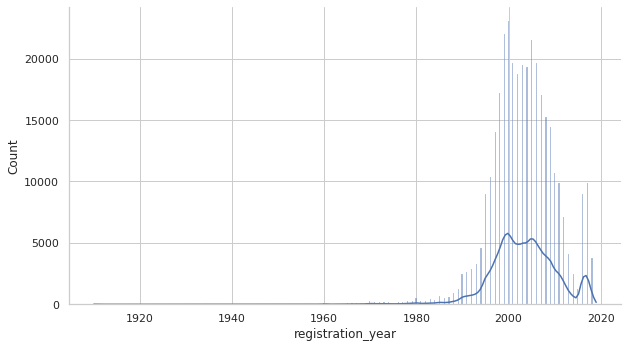

In [11]:
sns.displot(
    data=df['registration_year'][(df['registration_year']<2021) & (df['registration_year']>1885)], 
    kde=True, 
    aspect=16/9
);

Видно что есть провал продаж примерно между тремя и восемью годами с момента регистрации.  
В это время владельцы авто предпочитают ездить на нем сами.  
Ограничимся диапазоном от 1970 до 2020 года:  

In [12]:
df = df[(df['registration_year']<2020) & (df['registration_year']>1970)].reset_index(drop=True)

Поработаем с мощностью:  

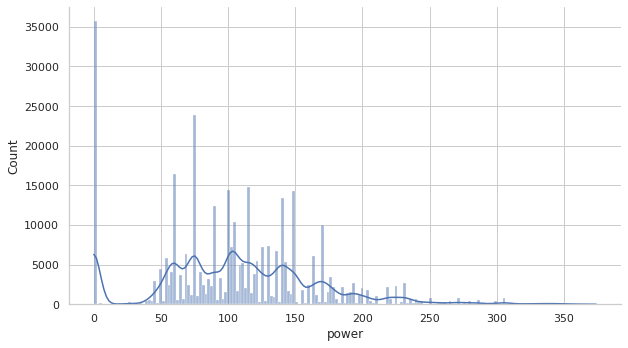

In [13]:
sns.displot(data=df['power'][df['power']<375], kde=True, aspect=16/9);

Оставим диапазон до 350л.с., нулей слишком много, заполним их позже:

In [14]:
df = df[df['power']<350].reset_index(drop=True)

Уберем колонки в которых везде только одно значение (`number_of_pictures`?), они на результат не влияют:

In [15]:
df = df[[column for column in df.columns if len(df[column].unique()) > 1]]

In [16]:
len(df.columns)

15

In [17]:
list(df)

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'not_repaired',
 'date_created',
 'postal_code',
 'last_seen']

Да, мы были правы насчет колонки с числом фотографий, в ней небыло значений кроме нуля.  
Сейчас удалилась одна колонка, и это именно `number_of_pictures`  
Нужно спросить у разработчиков почему эта колонка не была верно заполнена, а пока поработаем без нее.

Проверим оставшиеся нулевые значения:  

In [18]:

for column in df.columns:
    num_of_zeros_in_column = df[column][df[column]==0].count()
    if num_of_zeros_in_column > 0:
        print(column, num_of_zeros_in_column)
    

power 35711
registration_month 32335


Число нулей в этих колонках существенно, и нулей здесь быть не может, лучше их заменить на адекватные значения.    
Чтобы было удобно с ними работать, сначала заменим их на `nan`, а потом заполним адекватными значениями.

In [19]:
df[['power', 'registration_month']] = df[['power', 'registration_month']].replace(0, np.NaN)

Проверим общее количество пропусков в данных:  

In [20]:
df.isnull().mean().sort_values(ascending=False).round(3)

not_repaired          0.191
power                 0.105
vehicle_type          0.098
registration_month    0.095
fuel_type             0.085
model                 0.050
gearbox               0.049
last_seen             0.000
postal_code           0.000
date_created          0.000
brand                 0.000
kilometer             0.000
registration_year     0.000
price                 0.000
date_crawled          0.000
dtype: float64

`not_repaired` заполним случайными значениями, так мы не можем точно сказать было авто в ремонте или нет.  
Тоже самое с `registration_month`  

In [21]:
df['not_repaired'].value_counts()

no     242151
yes     33773
Name: not_repaired, dtype: int64

Заполним пустые значения случайным образом с учетом вероятности ремонта.  

In [22]:

num_of_no = len(
    df.query('not_repaired == "no"')
)
num_of_yes = len(
    df.query('not_repaired == "yes"')
)
random_repair = []

for i in range(
    len(
        df['not_repaired'][df['not_repaired'].isnull()]
    )
):
    random_repair.append(
        random.choices(
            ['no', 'yes'],
            weights=[num_of_no, num_of_yes]
        )
    )
    
df['not_repaired'][df['not_repaired'].isnull()] = random_repair


Заполним пустые значения `registration_month` случайным образом с учетом их вероятности.  

In [23]:
df['registration_month'].value_counts().sort_index()

1.0     22399
2.0     20667
3.0     33617
4.0     28525
5.0     28369
6.0     30615
7.0     26377
8.0     22012
9.0     23237
10.0    25479
11.0    23644
12.0    23632
Name: registration_month, dtype: int64

In [24]:

random_month = []
weights = []

for month in range(1, 13):
    weights.append(
        len(
            df.query('registration_month == @month')
           )
    )

for i in range(
    len(
        df['registration_month'][df['registration_month'].isnull()]
    )
):
    random_month.append(
        random.choices(
            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            weights=weights
        )
    )
    
df['registration_month'][df['registration_month'].isnull()] = random_month


Заполним остальные ключевым словом `unknown` для категорий, и медианным значением по группе для мощности.

In [25]:

imputer = SimpleImputer(strategy='constant', fill_value='unknown')
df[['vehicle_type','fuel_type','model', 'gearbox']] =\
imputer.fit_transform(df[['vehicle_type','fuel_type','model', 'gearbox']])


Проверим сколько уникальных значений скрывается в каждой колонке, расммотрим некоторые из них:      

In [26]:
print(df.nunique())

date_crawled          263667
price                   3717
vehicle_type               9
registration_year         49
gearbox                    3
power                    343
model                    251
kilometer                 13
registration_month        12
fuel_type                  8
brand                     40
not_repaired               2
date_created             109
postal_code             8137
last_seen             173675
dtype: int64


Есть и сотни тысяч и менее десяти.  

In [27]:
df.groupby(['vehicle_type'])['vehicle_type'].count()

vehicle_type
bus            28284
convertible    19704
coupe          15280
other           2981
sedan          88508
small          77810
suv            11606
unknown        33262
wagon          63473
Name: vehicle_type, dtype: int64

С типом ТС нет проблем, теперь посмотрим на тип коробки передач:  

In [28]:
df.groupby(['gearbox'])['gearbox'].count()

gearbox
auto        63969
manual     260109
unknown     16830
Name: gearbox, dtype: int64

Здесь тоже все хорошо, теперь модели:  

In [29]:
df.groupby(['model'])['model'].count()

model
100                     395
145                      45
147                     563
156                     602
159                     208
1_reihe                1270
1er                    3494
200                      17
2_reihe                4759
300c                    135
3_reihe                3421
3er                   19143
4_reihe                 618
500                     866
5_reihe                 436
5er                    7634
601                     326
6_reihe                1257
6er                     132
7er                     954
80                     1513
850                     206
90                       94
900                     114
9000                     28
911                      61
a1                      593
a2                      367
a3                     6019
a4                     9629
a5                      534
a6                     5345
a8                      492
a_klasse               4126
accord                  344
agila         

Модели в порядке, а что с типом топлива?  
Нам известно 3 основных типа: бензин, дизель, газ.  
В выборке их 8!

In [30]:
df.groupby(['fuel_type'])['fuel_type'].count()

fuel_type
cng            550
electric        85
gasoline     97028
hybrid         227
lpg           5119
other          149
petrol      208887
unknown      28863
Name: fuel_type, dtype: int64

Вот в чем дело:  
`cng` (Compressed Natural Gas) сжатый природный газ (метан)  
`electric` электричество  
`gasoline` бензин  
`hybrid` гибрид  
`lpg` (Liquified Petroleum Gas) сжиженный газ (пропан-бутан)  
Газ уже был, количество машин на газу небольшое, можно их объединить под общим названием `gas`  
`other` прочие  
`petrol` бензин  
Это повтор, в разных странах его называют по разному.  
Мы не будем объединять эти группы, их объем достаточно большой, и каждая может нести дополнительную информацию для модели, например Британское или Американское происхождение авто.  
`unknown` неизвестные

In [31]:

gas_ceils = []
df_gas = df['fuel_type'][df['fuel_type'].isin(['cng', 'lpg'])]

for ceil in range(len(df_gas)):
    gas_ceils.append('gas')

gas_ceils = pd.Series(gas_ceils)
gas_ceils.index = df_gas.index
df['fuel_type'][df['fuel_type'].isin(['cng', 'lpg'])] = gas_ceils


In [32]:
df.groupby(['fuel_type'])['fuel_type'].count()

fuel_type
electric        85
gas           5669
gasoline     97028
hybrid         227
other          149
petrol      208887
unknown      28863
Name: fuel_type, dtype: int64

Газ объединили.  
Посмотрим на бренды:  

In [33]:
df.groupby(['brand'])['brand'].count()

brand
alfa_romeo         2215
audi              28366
bmw               35583
chevrolet          1645
chrysler           1348
citroen            4988
dacia               889
daewoo              532
daihatsu            775
fiat               9236
ford              24269
honda              2710
hyundai            3530
jaguar              461
jeep                638
kia                2404
lada                213
lancia              449
land_rover          524
mazda              5457
mercedes_benz     30919
mini               3159
mitsubishi         2918
nissan             4797
opel              38329
peugeot           10756
porsche             654
renault           17335
rover               460
saab                514
seat               6703
skoda              5422
smart              5166
sonstige_autos     2447
subaru              729
suzuki             2271
toyota             4530
trabant             412
volkswagen        74075
volvo              3080
Name: brand, dtype: int64

Бренды в порядке.  
Заполним пропуски в мощности медианой по группам авто.  

In [34]:

df_grouped =\
df.groupby(['brand', 'model'])['power'].median().reset_index()
df_grouped.sample(5)


,brand,model,power
273,skoda,unknown,86.0
60,dacia,sandero,75.0
298,toyota,unknown,101.0
95,ford,kuga,140.0
287,suzuki,grand,129.0


In [35]:

# воспользуемся векторами и матрицами для скорости
matrix_with_power = np.array(df_grouped)

matrix_without_power = np.array(
    df[['brand', 'model', 'power']][df['power'].isna() == True]
)

true_power = []
start_time = datetime.now()

for vector_with_power in matrix_with_power:
    for vector_without_power in matrix_without_power:
        if np.array_equal(
            vector_with_power[:-1],
            vector_without_power[:-1]
        ):
            true_power.append(
                vector_with_power[-1:][0]
            )
            
print('Время работы (ч:м:с.мс) {}'.format(datetime.now()-start_time))            
            

Время работы (ч:м:с.мс) 0:01:41.347489


In [36]:

true_power = pd.Series(true_power)
true_power.index = df['power'][df['power'].isna() == True].index
df['power'][df['power'].isna() == True] = true_power


In [37]:
df.isna().mean().sort_values(ascending=False)

power                 0.000003
last_seen             0.000000
postal_code           0.000000
date_created          0.000000
not_repaired          0.000000
brand                 0.000000
fuel_type             0.000000
registration_month    0.000000
kilometer             0.000000
model                 0.000000
gearbox               0.000000
registration_year     0.000000
vehicle_type          0.000000
price                 0.000000
date_crawled          0.000000
dtype: float64

Осталось немного пустых значений, их можно удалить.  

In [38]:

df.dropna(inplace=True)
df.isna().mean().sort_values(ascending=False)


last_seen             0.0
postal_code           0.0
date_created          0.0
not_repaired          0.0
brand                 0.0
fuel_type             0.0
registration_month    0.0
kilometer             0.0
model                 0.0
power                 0.0
gearbox               0.0
registration_year     0.0
vehicle_type          0.0
price                 0.0
date_crawled          0.0
dtype: float64

Отлично, пропуски победили.  

In [39]:
print('Доля полных дубликатов в выборке составляет: {:3.2%}'.format(df.duplicated().mean()))

Доля полных дубликатов в выборке составляет: 0.00%


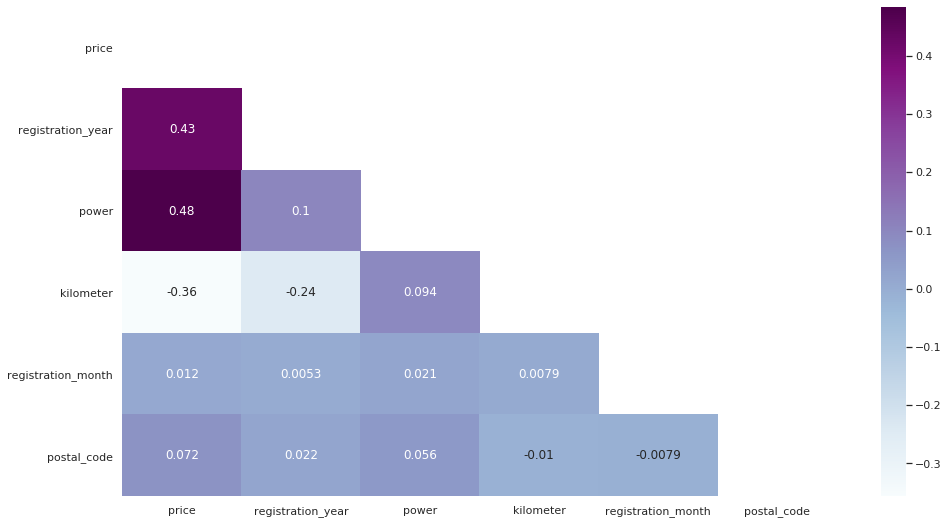

In [40]:

matrix = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(df.corr(), annot=True, mask=matrix, cmap='BuPu');


Наибольшую корреляцию с ценой имеют возраст, мощность и пробег.  
Вот только возраст у нас в неявном виде года регистрации.  
Однако, возраст это разница между годом регистрации и датой подачи объявления.  
Так сделаем возраст авто явным.  
А еще избавимся от колонок с датами, они будут мешать при дальнейшем кодировании признаков в числа.  
Таким образом мы получим пользу от колонок с датами, хотя могли их просто удалить.  

In [41]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,unknown,1993,manual,103.0,golf,150000,1.0,petrol,volkswagen,no,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,unknown,125000,5.0,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8.0,gasoline,jeep,no,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6.0,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7.0,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [42]:

year_created = pd.DatetimeIndex(df['date_created']).year
month_created = pd.DatetimeIndex(df['date_created']).month
# для приведения месяцев к десятичной доле года разделим их количество на 12 и затем на 1.2

df['car_age'] = round(
    year_created -\
    df['registration_year'] -\
    df['registration_month'] / 12 / 1.2 +\
    month_created / 12 / 1.2, 3
)


In [43]:
df['car_age'].head()

0    23.139
1     4.861
2    11.653
3    14.792
4     7.722
Name: car_age, dtype: float64

Отлично, мы получили возраст авто в чистом виде.  
Теперь можно удалить колонки с датами:

In [44]:
df.drop(['date_crawled', 'registration_year', 'registration_month', 'date_created', 'last_seen'], axis=1, inplace=True)

In [45]:
df.head()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,postal_code,car_age
0,480,unknown,manual,103.0,golf,150000,petrol,volkswagen,no,70435,23.139
1,18300,coupe,manual,190.0,unknown,125000,gasoline,audi,yes,66954,4.861
2,9800,suv,auto,163.0,grand,125000,gasoline,jeep,no,90480,11.653
3,1500,small,manual,75.0,golf,150000,petrol,volkswagen,no,91074,14.792
4,3600,small,manual,69.0,fabia,90000,gasoline,skoda,no,60437,7.722


In [46]:

# сделаем копию отдельно для LGBM, чтобы опробовать его собственные возможности кодировки кат. переменных
df_lgbm = df


Хорошо, теперь закодируем категориальные признаки техникой `Ordinal Encoding`  
Почему не `One Hot Encoding`?  

Потому что у нас есть сотни категорий, которые при `One Hot Encoding` превратятся в сотни столбцов всего с двумя значениями.   
Такое количество столбцов увеличит размер датасета в десятки раз.  
`Ordinal Encoding` просто запишет в столбец номер категории вместо ее названия.  

In [47]:

columns = [
    'vehicle_type',
    'gearbox',
    'kilometer',
    'fuel_type',
    'brand',
    'not_repaired',
    'model'
]

df[columns] = OrdinalEncoder().fit_transform(df[columns])


In [48]:
df.head()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,postal_code,car_age
0,480,7.0,1.0,103.0,116.0,12.0,5.0,38.0,0.0,70435,23.139
1,18300,2.0,1.0,190.0,228.0,11.0,2.0,1.0,1.0,66954,4.861
2,9800,6.0,0.0,163.0,117.0,11.0,2.0,14.0,0.0,90480,11.653
3,1500,5.0,1.0,75.0,116.0,12.0,5.0,38.0,0.0,91074,14.792
4,3600,5.0,1.0,69.0,101.0,9.0,2.0,31.0,0.0,60437,7.722


Для `LGBM` изменим тип колонок категориальных признаков:

In [49]:

for column in columns:
    df_lgbm[column] = df_lgbm[column].astype('category')


In [50]:
df_lgbm.dtypes

price              int64
vehicle_type    category
gearbox         category
power            float64
model           category
kilometer       category
fuel_type       category
brand           category
not_repaired    category
postal_code        int64
car_age          float64
dtype: object

Разобьем выборку на тренировочную и целевую.

In [51]:

y = df['price']
X = df.drop(['price'], axis=1)

# тоже для LGBM
y_lgbm = df_lgbm['price']
X_lgbm = df_lgbm.drop(['price'], axis=1)


Выделим тренировочные и тестовые части.

In [52]:

X_train, X_test, y_train, y_test =\
train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
)

# тоже для LGBM
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm =\
train_test_split(
    X_lgbm,
    y_lgbm,
    test_size=0.25,
    random_state=42
)


Масштабируем тестовые признаки.

In [53]:

# учим на тренировочной, масштабируем тестовую
scaler = StandardScaler()
columns = X_train.columns
scaler.fit(X_train[columns])
X_test = pd.DataFrame(scaler.transform(X_test[columns]), columns=columns)


### Вывод:
Мы полностью подготовили данные.  
Можно переходить к построению моделей.

## Обучение моделей

Сначала построим простый модели, подберем параметры с помощью поиска по сетке.

In [54]:

# создадим словарь с  моделями и их параметрами для перебора
# чтобы StandardScaler не учился на валидационной части при кросс-валидации тренировочной выборки:
# воспользуемся Pipeline

# для скорости проверки диапазоны настроек уже установлены близкими к оптимальным, вычисленным ранее

grid = {
    'LR': {
        'model': Pipeline([
            ('sc', StandardScaler()),
            ('lr', LinearRegression())
        ]),
        'parameters': {
            'lr__normalize': ['False']
        }
    },
    'DTR': {
        'model': Pipeline([
            ('sc', StandardScaler()),
            ('dtr', DecisionTreeRegressor(random_state=42))
        ]),
        'parameters': {
            'dtr__criterion': ['mse', 'friedman_mse'],
            'dtr__max_depth': [x for x in range(15, 20, 5)]
        }
    },
    'RFR': {
        'model': Pipeline([
            ('sc', StandardScaler()),
            ('rfr', RandomForestRegressor(random_state=42))
        ]),
        'parameters': {
           'rfr__n_estimators': [x for x in range(180, 200, 20)],
           'rfr__max_depth': [x for x in range(20, 22, 2)]
        }
    },
    'LGBM': {
        'model': Pipeline([
            ('sc', StandardScaler()),
            ('lgbm', lgb.LGBMModel())
        ]),
        'parameters': {
            'lgbm__learning_rate': [0.1, 0.12],
            'lgbm__objective': ['regression'],
            'lgbm__max_depth': [x for x in range(20, 25, 5)],
            'lgbm__n_estimators': [x for x in range(300, 350, 50)],
            'lgbm__num_iterations': [x for x in range(300, 350, 50)],
            'lgbm__boosting': ['gbdt']
        }
    }
}


In [55]:

RMSE = make_scorer(
    mean_squared_error,
    squared=False, # False берет корень квадратный из MSE, получаем RMSE
    greater_is_better=False
)

scores = []
start_time = datetime.now()

for model, parameter in grid.items():
    GS_CV = GridSearchCV(parameter['model'], 
                         parameter['parameters'], 
                         scoring = RMSE, 
                         cv=5
                        )
    GS_CV.fit(X_train,  y_train)
    scores.append({
    'model': model,
    'best_train_score': round(GS_CV.best_score_ * -1, 1), # умножая на -1 возвращаем верный знак нашей оценке
    'best_parameters': GS_CV.best_params_
    })
        
print('Время работы (ч:м:с.мс) {}'.format(datetime.now()-start_time))


Время работы (ч:м:с.мс) 0:21:51.088043


In [56]:

models_analysis = pd.DataFrame(scores, columns=[
    'model',
    'best_parameters',
    'best_train_score',
    'test_score',
    'training_time', 
    'prediction_time'
])
models_analysis.sort_values(by=['best_train_score'])


,model,best_parameters,best_train_score,test_score,training_time,prediction_time
3,LGBM,"{'lgbm__boosting': 'gbdt', 'lgbm__learning_rate': 0.12, 'lgbm__max_depth': 20, 'lgbm__n_estimators': 300, 'lgbm__num_iterations': 300, 'lgbm__objective': 'regression'}",1679.6,NaN,NaN,NaN
2,RFR,"{'rfr__max_depth': 20, 'rfr__n_estimators': 180}",1687.5,NaN,NaN,NaN
1,DTR,"{'dtr__criterion': 'mse', 'dtr__max_depth': 15}",2073.5,NaN,NaN,NaN
0,LR,{'lr__normalize': 'False'},3061.7,NaN,NaN,NaN


### Вывод:
Отлично, мы подобрали оптимальные параметры моделей.

## Анализ моделей

Давайте добавим время обучения/предсказания и RMSE на тесте в таблицу:

In [57]:
X_train = pd.DataFrame(scaler.transform(X_train[columns]), columns=columns)

In [58]:

LR = LinearRegression(normalize=False)

DTR = DecisionTreeRegressor(
    max_depth=15,
    criterion='friedman_mse',
    random_state=123
)

RFR = RandomForestRegressor(
    max_depth=20,
    n_estimators=180,
    random_state=123
)

LGBM = lgb.LGBMModel(
    learning_rate=0.12,
    objective='regression',
    max_depth=20,
    n_estimators=300,
    num_iterations=300,
    boosting='gbdt'
)

models = [LR, DTR, RFR, LGBM]


In [59]:

for i, model in enumerate(models):
    start_time = datetime.now()
    model.fit(X_train, y_train)
    models_analysis['training_time'][i] = datetime.now() - start_time
    
    start_time = datetime.now()
    predictions = model.predict(X_test)
    models_analysis['prediction_time'][i] = datetime.now() - start_time
    
    models_analysis['test_score'][i] = round(mean_squared_error(y_test, predictions, squared=False), 1)
        

In [60]:
models_analysis

,model,best_parameters,best_train_score,test_score,training_time,prediction_time
0,LR,{'lr__normalize': 'False'},3061.7,3039.4,0:00:00.063589,0:00:00.049206
1,DTR,"{'dtr__criterion': 'mse', 'dtr__max_depth': 15}",2073.5,2026.8,0:00:01.480445,0:00:00.025137
2,RFR,"{'rfr__max_depth': 20, 'rfr__n_estimators': 180}",1687.5,1650.0,0:03:33.435503,0:00:06.104334
3,LGBM,"{'lgbm__boosting': 'gbdt', 'lgbm__learning_rate': 0.12, 'lgbm__max_depth': 20, 'lgbm__n_estimators': 300, 'lgbm__num_iterations': 300, 'lgbm__objective': 'regression'}",1679.6,1655.2,0:00:36.656824,0:00:02.986414


Отдельно проверим как `LGBM` сам работает с категориальными признаками: 

In [61]:

start_time = datetime.now()
LGBM.fit(X_train_lgbm, y_train_lgbm)
models_analysis = models_analysis.append({'model': 'LGBM_self_encoder'}, ignore_index=True)
models_analysis['training_time'][4] = datetime.now() - start_time

start_time = datetime.now()
predictions = LGBM.predict(X_test_lgbm)
models_analysis['prediction_time'][4] = datetime.now() - start_time

models_analysis['test_score'][4] = round(mean_squared_error(y_test_lgbm, predictions, squared=False), 1)


In [62]:
models_analysis.iloc[[4], [0, 3, 4, 5]]

,model,test_score,training_time,prediction_time
4,LGBM_self_encoder,1614.9,0:00:25.756803,0:00:03.404312


Даже без кроссвалидации и масштабирования `LGBM` отлично справился.

### Вывод:

Из обычных моделей лучшее качество показал `Случайный Лес`, но он в десятки раз медленнее остальных алгоритмов.  
А вот алгоритм `LGBM` обладает всеми качествами, которые важны заказчику:  
- Качеством предсказания (на уровне Случайного Леса)
- Скоростью обучения (около 10 раз быстрее Случайного Леса)
- Скоростью предсказания (втрое быстрее Случайного Леса)  

Кроме того, `LGBM` сам может работать с категориальными признаками, и не требует кодировать их предварительно.  
Мы проверили это отдельно, и качество на тестовой выборке не пострадало.  
При этом мы не масштабировали признаки, не подбирали новые параметры (использовали имеющиеся).  
Только привели категориальные колонки к нужному формату.  
Время обучения выросло как, и время предсказания.  
Но все равно показатели достойные.  

## Общий вывод:
Изначально мы столкнулись с большим количеством артефактов в выборке.  
Нулевые цены, странные годы регистрации, большой разброс мощности.  
По пробегу видно что он ограничен 150 000км, возможно продавцы не хотят указывать больше.  
Число фото не заполнено, много нулей в месяце регистрации.  
Отсутствовал возраст авто в чистом виде.  
Бензин, как топливо, назывался двумя разными словами.  
Мы обработали данные и подготовили их к моделированию.  
Увидели провал продаж примерно между тремя и восемью годами с момента регистрации.  
Нашли корреляцию возраста, мощности и пробега с ценой.  
Вычислили возраст авто по нескольким колонкам с датами.  
Нашли алгоритм который подходит по всем трем параметрам:  
- Качеством предсказания  
- Скоростью обучения  
- Скоростью предсказания  

Им стал `LGBM`